In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np 
from scipy.stats import kstest
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams.update({'font.size': 24})


## import data

In [2]:
data = pd.read_csv('../data/allClinvarMissense.csv',header=0,index_col=0)
TFs = pd.read_csv('../data/TFs_GO0003700_human.tsv',delimiter='\t',header=0,index_col=0)
kinases = pd.read_csv('../data/kinases_GO00163001_human.tsv',delimiter='\t',header=0,index_col=0)
GPCRs = pd.read_csv('../data/GPCRs_GO0004930_human.tsv',delimiter='\t',header=0,index_col=0)

## cleanup

In [3]:
data['class']='none'
data.loc[data['upID'].isin(kinases.index),'class']='kinase'
data.loc[data['upID'].isin(TFs.index),'class']='TF'
data.loc[data['upID'].isin(GPCRs.index),'class']='GPCR'
data['disease_associated']='NO'
data.loc[~data['disease'].str.contains('not'),'disease_associated']='YES'
data['more_pos']='NO'
data['more_neg']='NO'
data.loc[data['changeType'].str.contains('neg>|>pos'),'more_pos']='YES'
data.loc[data['changeType'].str.contains('>neg|pos>'),'more_neg']='YES'
data['significance']=data['signi']
data.loc[data['signi'].str.contains('Benign|benign'),'significance']='Likely_benign'
data.loc[data['signi'].str.contains('Conflicting'),'significance']='Unknown_significance'
data.loc[data['signi'].str.contains(r'uncertain',case=False),'significance']='Unknown_significance'
data.loc[data['signi'].str.contains(r'pathogenic|risk',case=False),'significance']='Likely_pathogenic'
data.loc[data['signi'].str.contains(r'other|protective|drug|not_provided|Affects|sensitivity|unflagged|association',case=False),'significance']='Not_provided'
data['resDisordered']='ND'
data.loc[data['res_disorder']>0.7,'resDisordered']='YES'
data.loc[data['res_disorder']<0.3,'resDisordered']='NO'

## counts

In [4]:
N_all_prots = data[['upID','N_res','N_disordered']].drop_duplicates().shape[0]
N_all = data.shape[0]
N_all_diseaseAssociated = data[data['disease_associated']=='YES'].shape[0]
N_all_unknownSig = data[data['significance']=='Unknown_significance'].shape[0]
N_IDR = data[data['resDisordered']=='YES'].shape[0]
N_IDR_diseaseAssociated = data[(data['resDisordered']=='YES')&(data['disease_associated']=='YES')].shape[0]
N_IDR_unknownSig = data[(data['resDisordered']=='YES')&(data['significance']=='Unknown_significance')].shape[0]
N_expand = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_logFC_50']>0)&(data['mut_vs_wt_Re_pval_50']>1.3)].shape[0]
N_compact = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_logFC_50']<0)&(data['mut_vs_wt_Re_pval_50']>1.3)].shape[0]
N_nochange = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_pval_50']<1.3)].shape[0]
N_Re_change = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_pval_50']>1.3)].shape[0]
N_Re_change_prots = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_pval_50']>1.3)]['upID'].unique().shape[0]
print('total proteins in dataset: %i' % N_all_prots)
print('total variants in IDRs / all / ratio: %i / %i / %.2f' % (N_IDR,N_all,N_IDR/N_all))
print('ratio of disease associated variants in IDRs / all: %.2f / %.2f'%
      (N_IDR_diseaseAssociated/N_IDR,N_all_diseaseAssociated/N_all))
print('ratio of VUSs in IDRs / all: %.3f / %.3f' % 
      (N_IDR_unknownSig/N_IDR,N_all_unknownSig/N_all))
print('total variants that expand/compact/do nothing in IDRs: %i / %i / %i' % 
      (N_expand,N_compact,N_nochange))
print('total number of variants that change ensemble: %i in %i proteins'%(N_Re_change,N_Re_change_prots))

total proteins in dataset: 19981
total variants in IDRs / all / ratio: 277103 / 971579 / 0.29
ratio of disease associated variants in IDRs / all: 0.26 / 0.30
ratio of VUSs in IDRs / all: 0.842 / 0.848
total variants that expand/compact/do nothing in IDRs: 2982 / 8340 / 265300
total number of variants that change ensemble: 11322 in 4415 proteins


## histograms of variant Re of different lengths

Text(0.5, 0, '$\\langle R_e \\rangle \\ (\\AA)$')

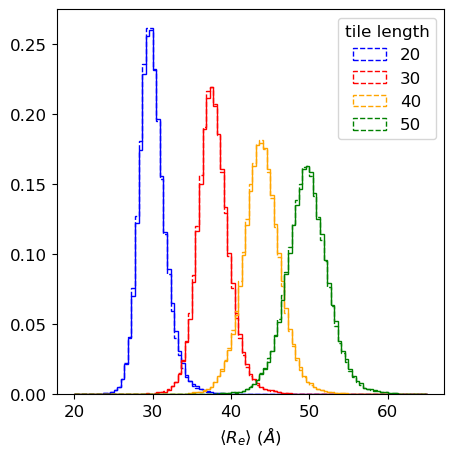

In [7]:
fig,ax = plt.subplots(figsize=[5,5])
bins = np.linspace(20,65,100)
colors=['blue','red','orange','green']
for i,window in enumerate(['20','30','40','50']):
    _=ax.hist(data.loc[(data['resDisordered']=='YES'),'mut_Re_avg_'+window],linestyle='--',density=True,bins=bins,histtype='step',color=colors[i],label=window)
    _=ax.hist(data.loc[(data['resDisordered']=='YES'),'wt_Re_avg_'+window],density=True,bins=bins,histtype='step',color=colors[i])
ax.legend(title='tile length')
ax.set_xlabel(r'$\langle R_e \rangle \ (\AA)$')

## Re Volcano plots for different tile lengths

20-res tiles: no change: 230058 (0.83), compacting: 31542 (0.11), expanding: 15022 (0.05)
30-res tiles: no change: 223253 (0.81), compacting: 35942 (0.13), expanding: 17427 (0.06)
40-res tiles: no change: 270174 (0.98), compacting: 4845 (0.02), expanding: 1603 (0.01)
50-res tiles: no change: 265316 (0.96), compacting: 8328 (0.03), expanding: 2978 (0.01)


(-5.0, 5.0)

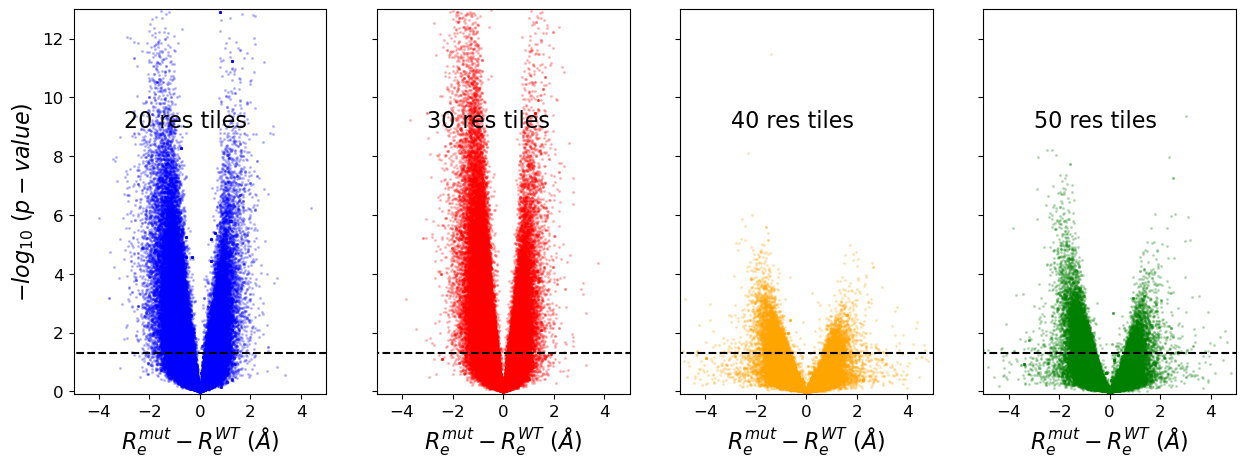

In [9]:
fig,ax=plt.subplots(1,4,figsize=[15,5],sharex=True,sharey=True)
window='30'
p_val_max=-np.log10(0.05)
delta_min = 0
colors=['blue','red','orange','green']

for i,window in enumerate(['20','30','40','50']):
    sliced=data[(data['resDisordered']=='YES')]
    N_expand = sliced[(sliced['mut_vs_wt_Re_delta_'+window]>0)&(sliced['mut_vs_wt_Re_pval_'+window]>p_val_max)].shape[0]
    N_compact = sliced[(sliced['mut_vs_wt_Re_delta_'+window]<0)&(sliced['mut_vs_wt_Re_pval_'+window]>p_val_max)].shape[0]
    N_nochange = sliced[(sliced['mut_vs_wt_Re_pval_'+window]<p_val_max)].shape[0]
    N_tot = N_expand+N_compact+N_nochange
    print('%s-res tiles: no change: %i (%.2f), compacting: %i (%.2f), expanding: %i (%.2f)'%
          (window, N_nochange,N_nochange/N_tot,N_compact,N_compact/N_tot,N_expand,N_expand/N_tot))
   # ax_inset = ax[i].inset_axes([0.6, 0.6, 0.3, 0.3])
   # ax_inset.pie([N_expand,N_compact], colors=['blue','red'])
    ax[i].scatter(sliced['mut_vs_wt_Re_delta_'+window],sliced['mut_vs_wt_Re_pval_'+window],
                s=1.5,alpha=0.2,color=colors[i])
    ax[i].plot([-10,10],[1.3,1.3],'--',c='k')
    ax[i].text(-3,9,window+' res tiles',fontsize=16)
    ax[i].set_xlabel('$R_{e}^{mut}-R_{e}^{WT}\ (\AA)$',fontsize=16)
ax[0].set_ylabel('$-log_{10}\ (p-value)$',fontsize=16)
ax[0].set_ylim(-0.1,13)
ax[0].set_xlim(-5,5)

## Volcano for Fig. 2

C:\Users\ssukenik\AppData\Local\Temp\ipykernel_22448\4247730482.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced.loc[sliced.index,'color']='grey'


total: 277103, no change: 223253 (0.806), compacting: 35942 (0.130), expanding: 17427 (0.063)
15095


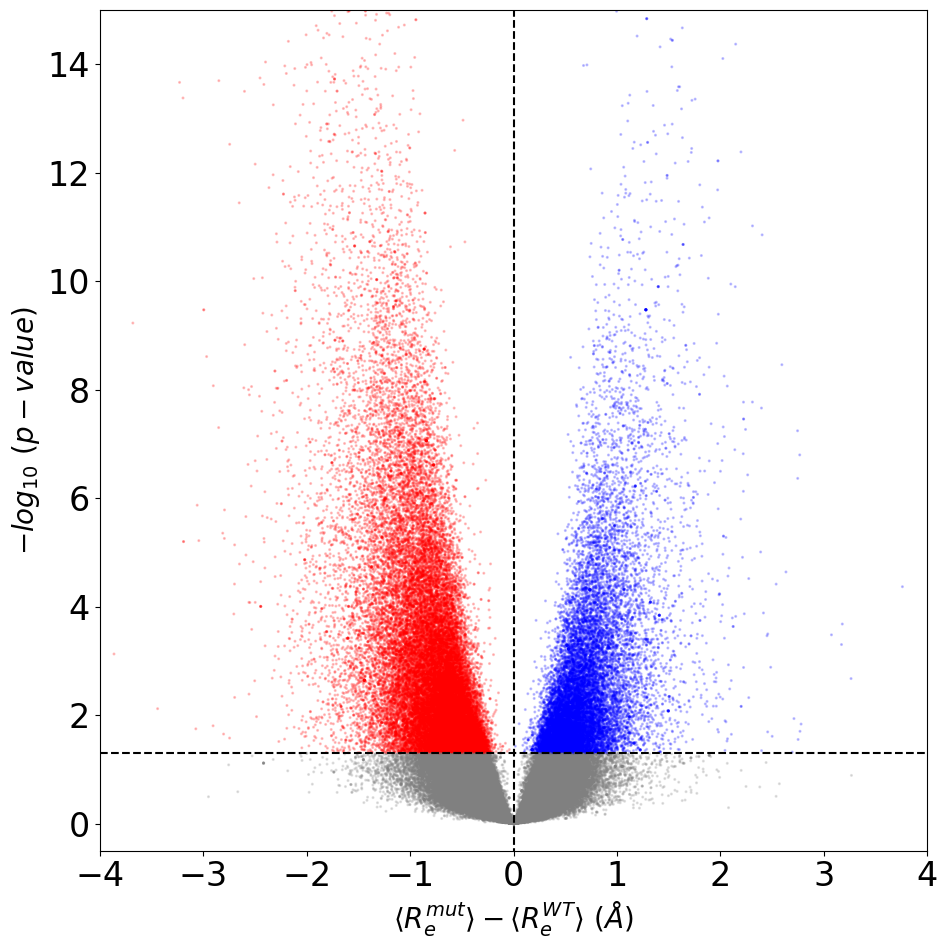

In [39]:
fig,ax=plt.subplots(figsize=[10,10])
window='30'
p_val_max=-np.log10(0.05)
delta_min = 0

sliced=data[(data['resDisordered']=='YES')]
sliced.loc[sliced.index,'color']='grey'
sliced.loc[(sliced['mut_vs_wt_Re_delta_'+window]>delta_min)&(sliced['mut_vs_wt_Re_pval_'+window]>p_val_max),'color']='b'
sliced.loc[(sliced['mut_vs_wt_Re_delta_'+window]<-delta_min)&(sliced['mut_vs_wt_Re_pval_'+window]>p_val_max),'color']='r'
ax.scatter(sliced['mut_vs_wt_Re_delta_'+window],sliced['mut_vs_wt_Re_pval_'+window],
                s=1.5,alpha=0.2,color=sliced['color'])
ax.plot([-4,4],[p_val_max,p_val_max],'--',c='k')
ax.plot([0,0],[-1,20],'--',c='k')
#ax.plot([-1,-1],[-1,20],'--',c='k')

ax.set_xlim(-4,4)
ax.set_ylim(-0.5,15)
ax.set_xlabel(r'$\langle R_e^{mut} \rangle - \langle R_e^{WT} \rangle \ (\AA)$',fontsize=20)
ax.set_ylabel('$-log_{10}\ (p-value)$',fontsize=20)

N_expand = sliced[(sliced['mut_vs_wt_Re_delta_'+window]>delta_min)&(sliced['mut_vs_wt_Re_pval_'+window]>p_val_max)].shape[0]
N_compact = sliced[(sliced['mut_vs_wt_Re_delta_'+window]<-delta_min)&(sliced['mut_vs_wt_Re_pval_'+window]>p_val_max)].shape[0]
N_nochange = sliced[(sliced['mut_vs_wt_Re_pval_'+window]<p_val_max)].shape[0]
print('total: %i, no change: %i (%.3f), compacting: %i (%.3f), expanding: %i (%.3f)'%
      (len(sliced),N_nochange,N_nochange/len(sliced),N_compact,N_compact/len(sliced),N_expand,N_expand/len(sliced)))

N_proteins = len(sliced['upID'].unique())
print(N_proteins)
#ax_inset = ax.inset_axes([0.32, 0.4, 0.4, 0.4])
#a=ax_inset.pie([N_nochange,N_expand,N_compact], colors=['grey','blue','red'],labels=['no\nchange','expand','compact'])
#ax_inset.set_title('mutation effect')
plt.tight_layout()
plt.savefig('volcano.png')


## Mutations by type

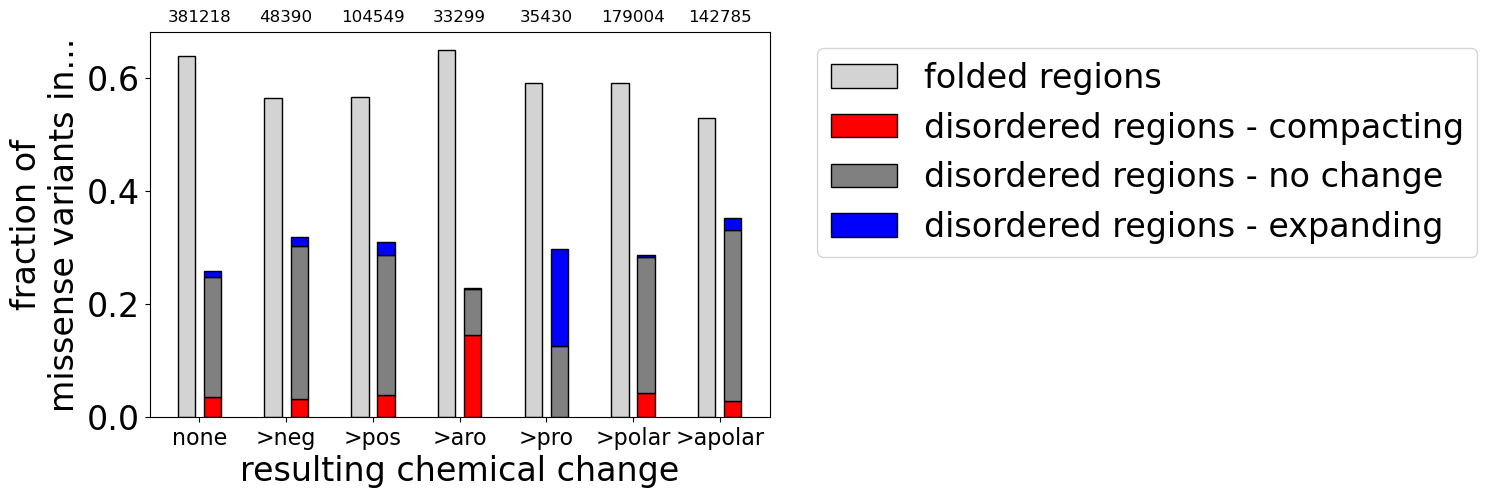

In [31]:
types = pd.DataFrame(index=data['changeType'].unique(),columns=['disordered','all','folded'])
changetypes=['none','>neg','>pos','>aro','>pro','>polar','>apolar']
fig,ax = plt.subplots(figsize=[8,5])
for i,changeType in enumerate(changetypes):
    sliced = data[data['changeType'].str.contains(changeType)]
    N_all = sliced.shape[0]
    N_folded = sliced[sliced['resDisordered']=='NO'].shape[0]
    N_disordered_compact = sliced[(sliced['resDisordered']=='YES')&(sliced['mut_vs_wt_Re_delta_30']<0)&(sliced['mut_vs_wt_Re_pval_30']>1.3)].shape[0]
    N_disordered_expand = sliced[(sliced['resDisordered']=='YES')&(sliced['mut_vs_wt_Re_delta_30']>0)&(sliced['mut_vs_wt_Re_pval_30']>1.3)].shape[0]
    N_disordered_nochange = sliced[(sliced['resDisordered']=='YES')&(sliced['mut_vs_wt_Re_pval_30']<1.3)].shape[0]
#   print('all: %i, folded: %i, disordered: %i'%(N_all,N_folded,N_disordered_compact+N_disordered_nochange))
    #ax.bar(i-0.3,N_all,width=0.2)
    ax.text(i,0.7,str(N_all),ha='center',fontsize=12)
    ax.bar(i-0.15,N_folded/N_all,width=0.2,color='lightgrey',edgecolor='k',label='folded regions')
    ax.bar(i+0.15,N_disordered_compact/N_all,width=0.2,color='red',edgecolor='k',label='disordered regions - compacting')
    ax.bar(i+0.15,N_disordered_nochange/N_all,bottom=(N_disordered_compact)/N_all,width=0.2,color='grey',edgecolor='k',label='disordered regions - no change')
    ax.bar(i+0.15,N_disordered_expand/N_all,bottom=(N_disordered_nochange+N_disordered_compact)/N_all,width=0.2,color='blue',edgecolor='k',label='disordered regions - expanding')
    if i==0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(changetypes,fontsize=16)
ax.set_xlabel('resulting chemical change')
_=ax.set_ylabel('fraction of\nmissense variants in...')

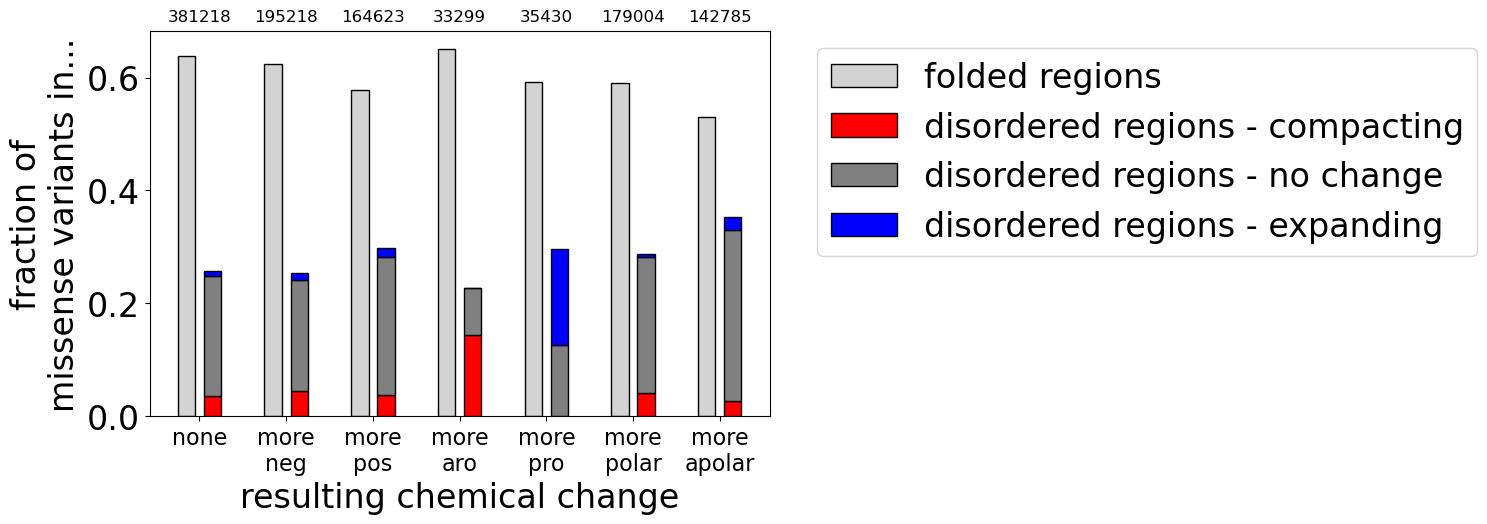

In [33]:
types = pd.DataFrame(index=data['changeType'].unique(),columns=['disordered','all','folded'])
changetypes=['none','pos>|>neg','neg>|>pos','>aro','>pro','>polar','>apolar']
fig,ax = plt.subplots(figsize=[8,5])
for i,changeType in enumerate(changetypes):
    sliced = data[data['changeType'].str.contains(changeType)]
    N_all = sliced.shape[0]
    N_folded = sliced[sliced['resDisordered']=='NO'].shape[0]
    N_disordered_compact = sliced[(sliced['resDisordered']=='YES')&(sliced['mut_vs_wt_Re_delta_30']<0)&(sliced['mut_vs_wt_Re_pval_30']>1.3)].shape[0]
    N_disordered_expand = sliced[(sliced['resDisordered']=='YES')&(sliced['mut_vs_wt_Re_delta_30']>0)&(sliced['mut_vs_wt_Re_pval_30']>1.3)].shape[0]
    N_disordered_nochange = sliced[(sliced['resDisordered']=='YES')&(sliced['mut_vs_wt_Re_pval_30']<1.3)].shape[0]
#   print('all: %i, folded: %i, disordered: %i'%(N_all,N_folded,N_disordered_compact+N_disordered_nochange))
    #ax.bar(i-0.3,N_all,width=0.2)
    ax.text(i,0.7,str(N_all),ha='center',fontsize=12)
    ax.bar(i-0.15,N_folded/N_all,width=0.2,color='lightgrey',edgecolor='k',label='folded regions')
    ax.bar(i+0.15,N_disordered_compact/N_all,width=0.2,color='red',edgecolor='k',label='disordered regions - compacting')
    ax.bar(i+0.15,N_disordered_nochange/N_all,bottom=(N_disordered_compact)/N_all,width=0.2,color='grey',edgecolor='k',label='disordered regions - no change')
    ax.bar(i+0.15,N_disordered_expand/N_all,bottom=(N_disordered_nochange+N_disordered_compact)/N_all,width=0.2,color='blue',edgecolor='k',label='disordered regions - expanding')
    if i==0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(['none','more\nneg','more\npos','more\naro','more\npro','more\npolar','more\napolar'],fontsize=16)
ax.set_xlabel('resulting chemical change')
_=ax.set_ylabel('fraction of\nmissense variants in...')
plt.savefig('missense_changes.svg')

## Output for GO onthology

In [21]:
Re_all_prots = data[(data['resDisordered']=='YES')]['upID'].unique()
Re_compact_prots = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_delta_20']<-1.5)&(data['mut_vs_wt_Re_pval_20']>1.3)]['upID'].unique()
Re_expand_prots = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_delta_20']>1.5)&(data['mut_vs_wt_Re_pval_20']>1.3)]['upID'].unique()

np.savetxt('compact.txt', Re_compact_prots, delimiter=',',fmt='%s') 
np.savetxt('expand.txt', Re_expand_prots, delimiter=',',fmt='%s') 
np.savetxt('all.txt', Re_all_prots, delimiter=',',fmt='%s')

TF: no change: 23473, compacting: 3616, expanding: 1872


Text(0, 0.5, '$-log_{10}\\ (p-value)$')

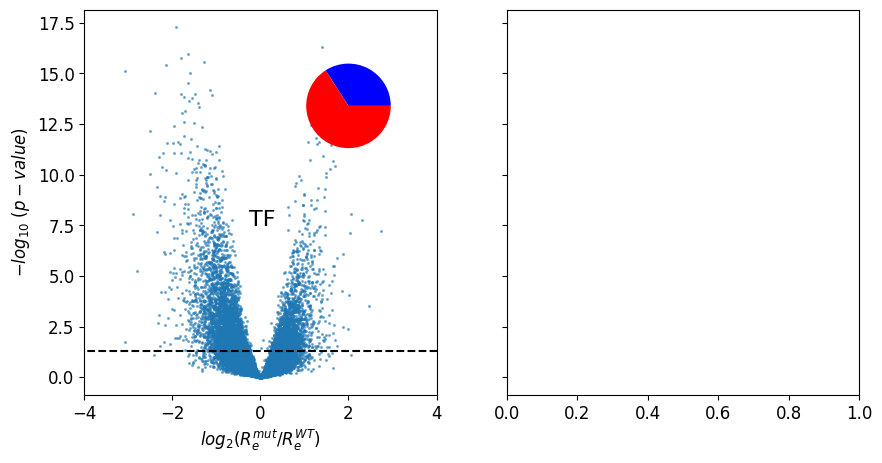

In [49]:
fig,ax=plt.subplots(1,2,figsize=[10,5],sharey=True)
for i,protClass in enumerate(['TF']):
    sliced=data[(data['resDisordered']=='YES')&(data['class']==protClass)]
    N_expand = sliced[(sliced['mut_vs_wt_Re_delta_30']>0)&(sliced['mut_vs_wt_Re_pval_30']>1.3)].shape[0]
    N_compact = sliced[(sliced['mut_vs_wt_Re_delta_30']<0)&(sliced['mut_vs_wt_Re_pval_30']>1.3)].shape[0]
    N_nochange = sliced[(sliced['mut_vs_wt_Re_pval_30']<1.3)].shape[0]
    print('%s: no change: %i, compacting: %i, expanding: %i'%
          (protClass,N_nochange,N_compact,N_expand))
    ax_inset = ax[i].inset_axes([0.6, 0.6, 0.3, 0.3])
    ax_inset.pie([N_expand,N_compact], colors=['blue','red'])
    ax[i].scatter(sliced['mut_vs_wt_Re_delta_30'],sliced['mut_vs_wt_Re_pval_30'],
                s=1.5,alpha=0.5)
    ax[i].plot([-10,10],[1.3,1.3],'--',c='k')
    ax[i].set_xlim(-4,4)
    ax[i].text(-0.27,7.5,protClass,fontsize=16)
    ax[i].set_xlabel('$log_2(R_{e}^{mut}/R_{e}^{WT})$')
ax[0].set_ylabel('$-log_{10}\ (p-value)$')

In [7]:
sliced = data[(data['resDisordered']=='YES')&(data['disease_associated']=='YES')]
N=sliced.shape[0]
df = (sliced.groupby('changeType')['upID'].count()/N)
types.loc[df.index,'disordered']=df.values
sliced = data[(data['resDisordered']=='NO')&(data['disease_associated']=='YES')]
N=sliced.shape[0]
df = (sliced.groupby('changeType')['upID'].count()/N)
types.loc[df.index,'folded']=df.values
sliced = data[(data['disease_associated']=='YES')]
N=sliced.shape[0]
df = (sliced.groupby('changeType')['upID'].count()/N)
types.loc[df.index,'all']=df.values
fig,ax = plt.subplots()

print(types.sort_values(by='disordered',ascending=False).head(20))

             disordered       all    folded
none           0.360035  0.397563  0.417211
polar>apolar   0.090329  0.072159  0.065007
polar>pos      0.073612  0.063215   0.05806
pos>polar      0.065585  0.077069   0.08044
pro>polar      0.060022  0.032493  0.020168
pro>apolar     0.058473  0.032274  0.021056
neg>polar      0.044714  0.047354  0.047169
polar>neg      0.042376  0.033666  0.030209
neg>pos        0.020322  0.022222   0.02225
polar>pro      0.019745  0.016035  0.014555
apolar>pro     0.016759  0.020542    0.0226
polar>cys      0.016393  0.010031  0.007463
pro>pos        0.015139  0.008455  0.005359
neg>apolar     0.013675  0.014128  0.013937
pos>aro        0.013252  0.015434  0.015831
pos>cys        0.012787  0.018531    0.0207
apolar>neg     0.009816   0.01058   0.01109
pos>apolar     0.009281   0.01101  0.011289
apolar>pos     0.008605  0.010191  0.011069
pos>neg        0.008295  0.009163  0.009094


Text(0, 0.5, 'fraction of disease\nvariants with...')

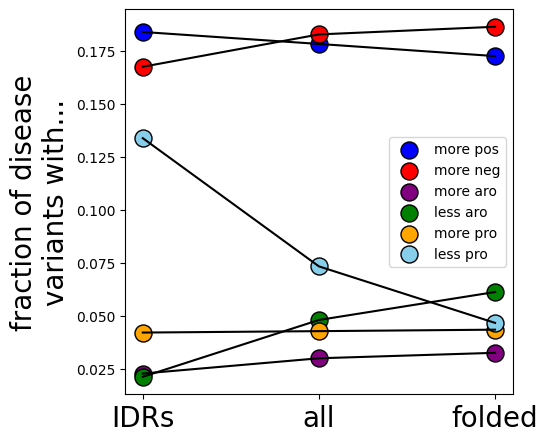

In [8]:
fig,ax= plt.subplots(figsize=[5,5])
kwargs={'edgecolor':'k','ms':150,'alpha':0.8}
df = types.filter(axis=0,regex='neg>|>pos').dropna()
ax.scatter([0,1,2],df.sum(axis=0).values,edgecolor='k',s=150,c='blue',label='more pos')
ax.plot([0,1,2],df.sum(axis=0).values,c='k')
df = types.filter(axis=0,regex='>neg|pos>').dropna()
ax.scatter([0,1,2],df.sum(axis=0).values,edgecolor='k',s=150,c='red',label='more neg')
ax.plot([0,1,2],df.sum(axis=0).values,c='k')
df = types.filter(axis=0,regex='>aro').dropna()
ax.scatter([0,1,2],df.sum(axis=0).values,edgecolor='k',s=150,c='purple',label='more aro')
ax.plot([0,1,2],df.sum(axis=0).values,c='k')
df = types.filter(axis=0,regex='aro>').dropna()
ax.scatter([0,1,2],df.sum(axis=0).values,edgecolor='k',s=150,c='green',label='less aro')
ax.plot([0,1,2],df.sum(axis=0).values,c='k')
df = types.filter(axis=0,regex='>pro').dropna()
ax.scatter([0,1,2],df.sum(axis=0).values,edgecolor='k',s=150,c='orange',label='more pro')
ax.plot([0,1,2],df.sum(axis=0).values,c='k')
df = types.filter(axis=0,regex='pro>').dropna()
ax.scatter([0,1,2],df.sum(axis=0).values,edgecolor='k',s=150,c='skyblue',label='less pro')
ax.plot([0,1,2],df.sum(axis=0).values,c='k')
ax.legend()
ax.set_xticks([0,1,2])
ax.set_xticklabels(['IDRs','all','folded'],fontsize=20)
ax.set_ylabel('fraction of disease\nvariants with...',fontsize=20)

In [9]:
Re_changes = pd.DataFrame(index=['compact','no change','expanded'],columns=['disease','no disease'])
sliced = data[(data['resDisordered']=='YES')&
              (data['disease_associated']=='YES')]
Re_changes.loc['compact','disease']=sliced[sliced['deltaRe']<-1].shape[0]
Re_changes.loc['expanded','disease']=sliced[sliced['deltaRe']>1].shape[0]
Re_changes.loc['no change','disease']=len(sliced)-Re_changes.loc['compact','disease']-Re_changes.loc['expanded','disease']
sliced = data[(data['resDisordered']=='YES')&
              (data['disease_associated']=='NO')]
Re_changes.loc['compact','no disease']=sliced[sliced['deltaRe']<-1].shape[0]
Re_changes.loc['expanded','no disease']=sliced[sliced['deltaRe']>1].shape[0]
Re_changes.loc['no change','no disease']=(len(sliced)-Re_changes.loc['compact','no disease']-Re_changes.loc['expanded','no disease'])

print(Re_changes)

KeyError: 'deltaRe'

In [10]:
#fraction of disordered missense variants
frac_disordered_missense = data[data['resDisordered']=='YES'].shape[0]/data.shape[0]
#fraction of disordered residues
allProts = data[['upID','N_res','N_disordered']]
frac_disordered_total = allProts['N_disordered'].sum()/allProts['N_res'].sum()

print('%.2f of missense mutations occur in IDRs\n  (%.2f residues in IDRs total)'
      %(frac_disordered_missense, frac_disordered_total))

frac_disease_assoc_total = data[data['disease_associated']=='YES']['upID'].count()/len(data)
frac_disease_assoc_in_IDRs = data[(data['disease_associated']=='YES')&
                                  (data['resDisordered']=='YES')]['upID'].count()/data[data['resDisordered']=='YES'].shape[0]
#print(frac_disease_assoc_total)
print('%.2f IDR missense mutations are disease associaed\n(%.2f in non-IDRs)'
      %(frac_disease_assoc_in_IDRs,frac_disease_assoc_total))

0.29 of missense mutations occur in IDRs
  (0.25 residues in IDRs total)
0.26 IDR missense mutations are disease associaed
(0.30 in non-IDRs)


([<matplotlib.patches.Wedge at 0x7f4990e52e60>,
 [Text(1.0425610692559644, 0.35080823375722026, 'Likely_benign'),
  Text(0.7529634563586782, 0.8019015110276281, 'Likely_pathogenic'),
  Text(0.6037316561774815, 0.9195151370854073, 'Not_provided'),
  Text(-0.9666370544883696, -0.5249883854810974, 'Unknown_significance')])

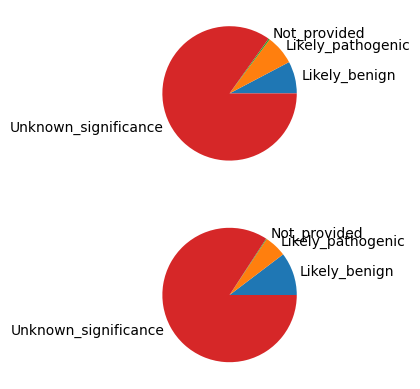

In [11]:
sliced = data[data['resDisordered']=='YES']
counts = data.groupby('significance').count()['upID']
labels = counts.index
sizes = counts.values
fig, ax = plt.subplots(2,1)
ax[0].pie(sizes, labels=labels)
counts = sliced.groupby('significance').count()['upID']
#for signi in counts.index:
    #print(data[(data['significance']==signi)&(data['disease_associated']=='YES')].count())
sizes = counts.values
ax[1].pie(sizes, labels=labels)

## distribution of disorder in clinvar proteins

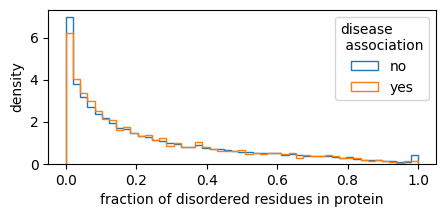

In [12]:
df = data[['upID','N_res','N_disordered','disease_associated']].drop_duplicates()
df['disordered_frac']=df['N_disordered']/df['N_res']
bins = np.linspace(0,1,50)
df2=df[df['disease_associated']=='NO']
fig,ax = plt.subplots(figsize=[5,2])
_=ax.hist(df2['disordered_frac'],bins=bins,histtype='step',density=True,label='no')
df3=df[df['disease_associated']=='YES']
_=ax.hist(df3['disordered_frac'],bins=bins,histtype='step',density=True,label='yes')
ax.set_xlabel('fraction of disordered residues in protein')
ax.set_ylabel('density')
ax.legend(title='disease\n association')

## fraction of variants significances

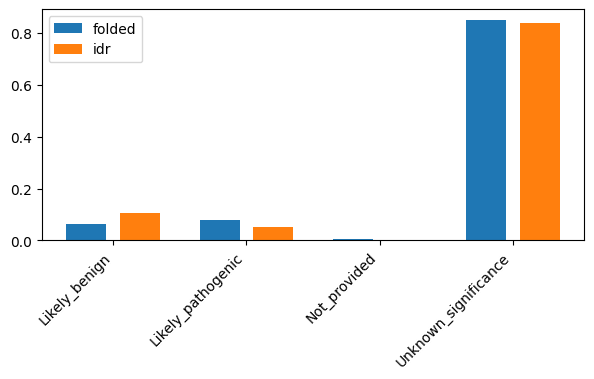

In [13]:
sl_folded = data[data['res_disorder']<0.5]
sl_idr = data[data['res_disorder']>0.8]
fig,ax=plt.subplots(figsize=[7,3])
idr_sig = sl_idr.groupby('significance')['upID'].count()
fol_sig = sl_folded.groupby('significance')['upID'].count()
df = pd.concat([idr_sig/idr_sig.sum(),fol_sig/fol_sig.sum()],axis=1).sort_index()
df.columns = ['idr','folded']
ax.bar(np.arange(len(df))-0.2,df['folded'],width=0.3,label='folded')
ax.bar(np.arange(len(df))+0.2,df['idr'],width=0.3,label='idr')
ax.set_xticks(np.arange(len(df)))
ax.set_xticklabels(df.index,rotation=45,ha='right')
ax.legend()

In [ ]:
sl_folded = data[data['res_disorder'] < 0.3]
sl_idr = data[data['res_disorder'] > 0.7]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [1, 2], 'hspace': 0.05})

idr_sig = sl_idr.groupby('significance')['upID'].count()
fol_sig = sl_folded.groupby('significance')['upID'].count()
df = pd.concat([idr_sig/idr_sig.sum(), fol_sig/fol_sig.sum()], axis=1).sort_index()
df.columns = ['idr', 'folded']

def plot_bars(ax, data, y_range):
    ax.bar(np.arange(len(data)) - 0.2, data['folded'], width=0.3, label='folded')
    ax.bar(np.arange(len(data)) + 0.2, data['idr'], width=0.3, label='idr')
    ax.set_ylim(y_range)
    ax.set_xticks(np.arange(len(data)))
    
# Plot lower part (0 to 0.2)
plot_bars(ax2, df, (0, 0.1))

# Plot upper part (0.6 to 1)
plot_bars(ax1, df, (0.6, 1))

# Set x-axis labels on the bottom axis
ax2.set_xticklabels(df.index, rotation=45, ha='right')

# Remove x-axis labels from the top axis
ax1.set_xticklabels([])

# Add break lines
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# Add legend to the top axis
ax2.legend()

# Add y-label
fig.text(0.04, 0.5, 'total variant fraction', va='center', rotation='vertical')

ax2.set_xticks(np.arange(len(df)))
ax2.set_xticklabels(df.index,rotation=45,ha='right')

plt.show()

In [ ]:
df = data[(data['resDisordered']=='YES')&(data['changeType'].str.contains('neg>pos|pos>neg'))][['localRe_change','changeType','significance']]
fig,ax=plt.subplots(figsize=[12,3])
sns.violinplot(x='changeType',y='localRe_change',hue='significance',data=df,ax=ax)
ax.plot([-10,10],[1,1],'--',c='k')
ax.set_xlim(-1,len(df['changeType'].drop_duplicates()))
_=ax.set_xticks(np.arange(len(df['changeType'].drop_duplicates())))
_=ax.set_xticklabels(df['changeType'].drop_duplicates(),rotation=45,ha='right')



In [ ]:
fig,ax=plt.subplots(figsize=[7,3])
sns.violinplot(x='significance',y='localRe_change',data=df,ax=ax)
ax.plot([-10,10],[1,1],'--',c='k')
ax.set_xlim(-1,len(df['significance'].drop_duplicates()))
_=ax.set_xticks(np.arange(len(df['significance'].drop_duplicates())))
_=ax.set_xticklabels(df['significance'].drop_duplicates(),rotation=45,ha='right')

In [ ]:
fig,ax=plt.subplots(figsize=[5,5])
df = data[(data['resDisordered']=='YES')&(data['disease_associated']=='NO')]
deltaRe=df['mutRe_local']-df['wtRe_local']
bins=np.linspace(-3,3,500)
s=deltaRe.groupby(pd.cut(deltaRe,bins=bins),observed=False).size()
ax.semilogy(bins[1:],s/s.sum(),label='no')
ax.set_xlabel(r'dRe')
ax.set_ylabel('variant count')
df = data[(data['resDisordered']=='YES')&(data['disease_associated']=='YES')]
deltaRe=df['mutRe_local']-df['wtRe_local']
bins=np.linspace(-3,3,500)
s=deltaRe.groupby(pd.cut(deltaRe,bins=bins),observed=False).size()
ax.semilogy(bins[1:],s/s.sum(),label='yes')
ax.semilogy([0,0],[0,(s/s.sum()).max()],'--',c='k',lw=0.5)
ax.set_xlabel(r'dRe')
ax.set_ylabel('variant count')
ax.legend(title='disease associated?')

In [ ]:
df=data[data['resDisordered']=='YES']#[data['deltaRe']<-0.5]
sig_cats = df['significance'].unique()
fig,ax=plt.subplots()
for i,sig in enumerate(sig_cats):
    sliced = df[df['significance']==sig]
    ax.violinplot(sliced['deltaRe'],positions=[i])
    ax.scatter(i,sliced['deltaRe'].median(),s=20,edgecolor='k',zorder=3)
    #pvalue = kstest(
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(sig_cats, rotation=90)

In [ ]:
data.columns